In [20]:
import jax.numpy as jnp
from jax import random

from jaxgp import FullGradient, FullIntegral, FullFunction
from jaxgp.kernels import RBF

import matplotlib.pyplot as plt

In [21]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return jnp.cos(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    return -jnp.sin(x) + random.normal(key,x.shape, dtype=jnp.float32)*noise

In [22]:
# Interval bounds from which to choose the data points
bounds = jnp.array([0.0, 2*jnp.pi])

# How many function and derivative observations should be chosen
n_data_int = (10,)
n_data_grad = (10,)

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_int = random.uniform(subkey, n_data_int, minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_grad = random.uniform(subkey, n_data_grad, minval=bounds[0], maxval=bounds[1])

x_int = jnp.linspace(*bounds, *n_data_int)
x_grad = jnp.linspace(*bounds, *n_data_grad)


# noise with which to sample the training labels
noise = 0.1
key, subkey = random.split(key)
y_int = grad(x_int, noise, subkey)
key, subkey = random.split(key)
y_grad = fun(x_grad, noise, subkey)

X_int = (jnp.zeros((1,1)), x_int.reshape(-1,1))
Y_int = jnp.hstack((jnp.ones(1), y_int))

X_grad = (x_grad.reshape(-1,1), jnp.zeros((1,1))*2*jnp.pi)
Y_grad = jnp.hstack((y_grad, jnp.zeros(1)))

X_func = x_grad.reshape(-1,1)
Y_func = y_grad

In [23]:
kernel = RBF()

noise_vec = jnp.hstack((jnp.zeros(1), jnp.ones(n_data_int)*noise))
model_int = FullIntegral(kernel, noise=noise_vec)

noise_vec = jnp.hstack((jnp.ones(n_data_int)*noise, jnp.zeros(1)))
model_grad = FullGradient(kernel, noise=noise_vec)

model_func = FullFunction(kernel, noise=noise)

In [24]:
model_int.train(X_int, Y_int)
model_grad.train(X_grad, Y_grad)
model_func.train(X_func, Y_func)

True
True
True


In [25]:
predict_grid = jnp.linspace(*bounds, 200)

mean, std = model_int.predict(predict_grid.reshape(-1,1))
mean_int = mean.reshape(-1)
std_int = std.reshape(-1)

mean, std = model_grad.predict(predict_grid.reshape(-1,1))
mean_grad = mean.reshape(-1)
std_grad = std.reshape(-1)

mean, std = model_func.predict(predict_grid.reshape(-1,1))
mean_func = mean.reshape(-1)
std_func = std.reshape(-1)

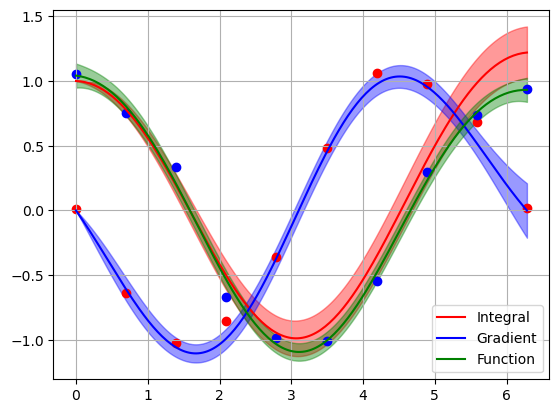

In [27]:
plt.plot(predict_grid, mean_int, color="r", label="Integral")
plt.fill_between(predict_grid, mean_int+std_int, mean_int-std_int, alpha=0.4, color="r")

plt.plot(predict_grid, mean_grad, color="b", label="Gradient")
plt.fill_between(predict_grid, mean_grad+std_grad, mean_grad-std_grad, alpha=0.4, color="b")


plt.plot(predict_grid, mean_func, color="g", label="Function")
plt.fill_between(predict_grid, mean_func+std_func, mean_func-std_func, alpha=0.4, color="g")

plt.scatter(X_int[1], Y_int[1:], color="r")
plt.scatter(X_grad[0], Y_grad[:-1], color="b")

plt.grid()
plt.legend()